In [2]:
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import scipy
import os

from utils import plot_histogram
from var import sc_data_folder, results_folder, today, color

In [3]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [4]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/perturbed_rna_exploration/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

<h3> 1. Data exploration of filtered data </h3>

In [5]:
#load log normlised adata object with filter for cells with more than 5000 UMI counts expressed
adata_preprocessed = sc.read_h5ad(f'/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230116_adata_pre_processed.h5ad')

In [6]:
#load adata obs object from crispra csv file
adata_obs_df=pd.read_csv('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/crispra_data_exploration/20230127_perturbation_state.csv', index_col=0)
#order index of adata_obs_df to match adata_preprocessed
adata_obs_df = adata_obs_df.reindex(adata_preprocessed.obs.index)
#check that the index of adata_obs_df matches adata_preprocessed
assert adata_obs_df.index.equals(adata_preprocessed.obs.index)
#overwrite adata_preprocessed.obs with adata_obs_df
adata_preprocessed.obs = adata_obs_df

#filter out cells that are not in the perturbation state
adata_pertubed = adata_preprocessed[adata_preprocessed.obs['perturbation_state'] != 'not_perturbed']

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

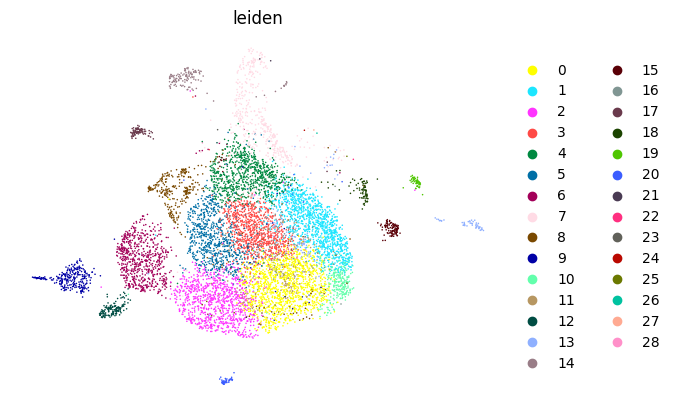

In [7]:
# Leiden clustering with resolution 2
sc.tl.leiden(adata_pertubed, resolution=1)
# Plot UMAP
sc.pl.umap(adata_pertubed, color=['leiden'],
           color_map = 'RdPu', ncols = 3, #legend_loc='on data',
           size=5,
           legend_fontsize=10,
           frameon=False,
           show=False
           )
# plt.savefig(f'{figures_folder}{today}_perturbed_leiden_res_1.pdf')

In [ ]:
#select all guides by selecting the names which do not start with ENSG in var_names
targeted_tf_guides = list(adata_pertubed.var_names[~adata_pertubed.var_names.str.startswith('ENSG')])
#use list comprehension to split targeted_tf_guides by '_' and select the first element of the list
targeted_tf = [x.split('_')[0] for x in targeted_tf_guides]

In [ ]:
ipsc_tf = ['SOX2', 'KLF4', 'POU5F1', 'NANOG']
cell_cycle = ['MKI67', 'PCNA']
targeted_tf_guides, targeted_tf, ipsc_tf, cell_cycle

In [ ]:
expected_guides = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2',
    'sgRNA1_SCP',
    'sgRNA6_SCP',
    'ONE_INTERGENIC_SITE_1194'
]

#filter targeted_tf_guides to only include guides which start with the expected_tfs
targeted_tf_guides = [x for x in targeted_tf_guides if x.split('_')[0] in expected_guides]

In [ ]:
targeted_tf_guides

In [ ]:
expected_tf = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2'
]

In [ ]:
len(expected_tf)

In [ ]:
len(np.unique(targeted_tf)), len(expected_guides)

<h3> 1.1 Differential gene expression analysis on filtered data </h3>

In [ ]:
sc.pl.dotplot(adata_pertubed, targeted_tf_guides ,
              standard_scale='var',
              groupby='leiden', color_map = 'RdPu',
              gene_symbols='SYMBOL', show=False)
#save plot 
# plt.savefig(f'{figures_folder}{today}_dotplot_guides_cluster.pdf',bbox_inches='tight')

sc.pl.umap(adata_pertubed, color=['perturbation_state'],
           color_map='RdPu', ncols=4, #legend_loc='on data',
           vmin=0, vmax='p99.999', size=10,
           legend_fontsize=10, gene_symbols='SYMBOL',show=False,frameon=False)
#save plot
plt.savefig(f'{figures_folder}{today}_umap_perturbed_state.pdf',bbox_inches='tight')


In [ ]:
perturbation_states = adata_pertubed.obs['perturbation_state'].unique()
n_rows = 5
#round up to get the number of rows

n_cols = np.round(len(perturbation_states)/n_rows).astype(int)
#use plt.subplots to create a figure with the number of rows and columns increase spacing between subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 15))
axes = axes.ravel()

for i, perturbation_state in enumerate(perturbation_states):
    adata_pertubed_state = adata_pertubed[adata_pertubed.obs['perturbation_state'] == perturbation_state]
    sc.pl.umap(adata_pertubed_state, color=['perturbation_state'],
                color_map='RdPu', ncols=4, #legend_loc='on data',
                size=5,
                legend_fontsize=10, gene_symbols='SYMBOL', ax=axes[i], show=False, legend_loc=None)
    #tight bbox
    plt.tight_layout()
    axes[i].set_title(perturbation_state)
#remove the axis from the last subplot as it is empty
axes[14].set_axis_off()


plt.savefig(f'{figures_folder}{today}_umap_targeting_plasmids_perturbed_state.pdf',bbox_inches='tight')            

In [ ]:
sc.pl.umap(adata_pertubed, color=expected_tf,
           color_map='RdPu', ncols=3, #legend_loc='on data',
           vmin=0, vmax='p99.99', size=10,
           legend_fontsize=10, gene_symbols='SYMBOL')

In [10]:
#log base lazer to none 
adata_pertubed.uns['log1p']["base"] = None
#excluding leiden clusters with only 1 cell based on adata obs
adata_filter_leiden=adata_pertubed.obs['leiden'].value_counts()[adata_pertubed.obs['leiden'].value_counts() > 1].index.tolist()
#filter adata_pertubed to only include leiden clusters with ffmore than 1 cell
adata_filter_leiden = adata_pertubed[adata_pertubed.obs['leiden'].isin(adata_filter_leiden)].copy()
#filter out guides from gene list in adata var which do not start with ENSG
adata_filter_leiden = adata_filter_leiden[:, adata_filter_leiden.var_names.str.startswith('ENSG')]


In [11]:
#log p transform counts
adata_filter_leiden.layers['log1p'] = np.log1p(adata_filter_leiden.layers['counts'])

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/tools/_rank_genes_g

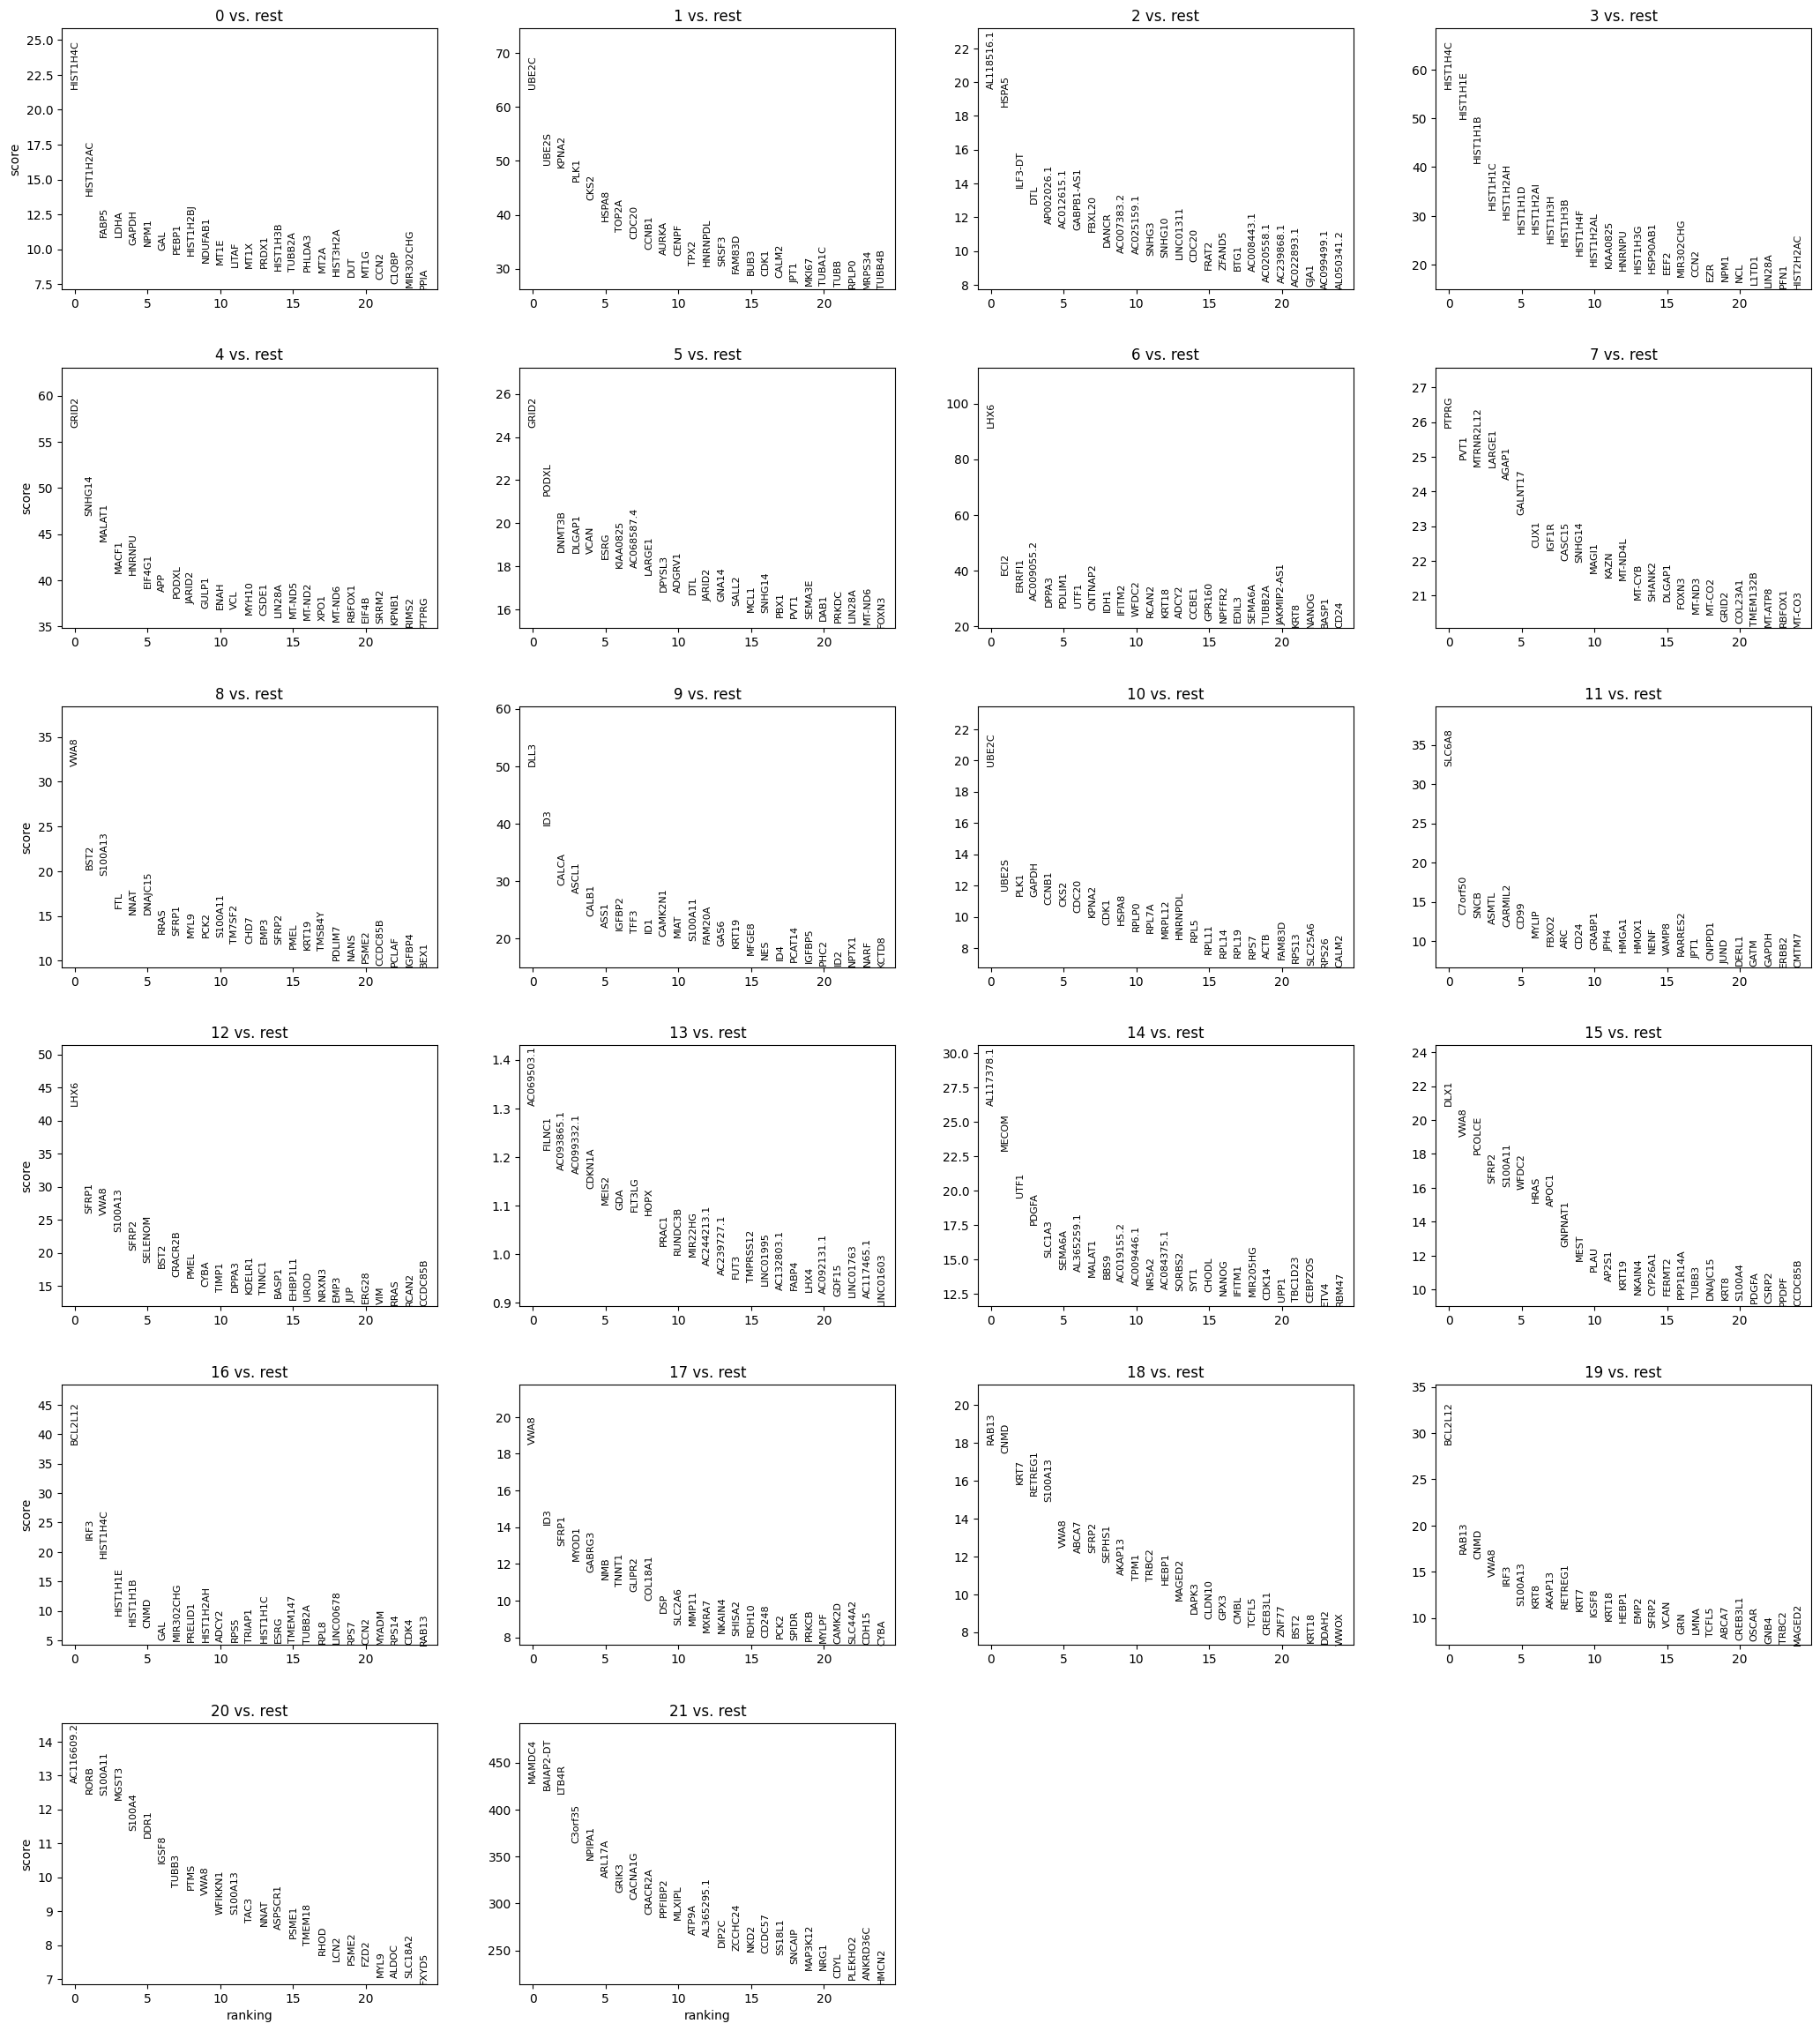

In [14]:
#ranked genes based on clustering on layer log1p
sc.tl.rank_genes_groups(adata_filter_leiden, 'leiden', method='t-test', layer='log1p')
sc.pl.rank_genes_groups(adata_filter_leiden, n_genes=25, sharey=False, gene_symbols='SYMBOL')

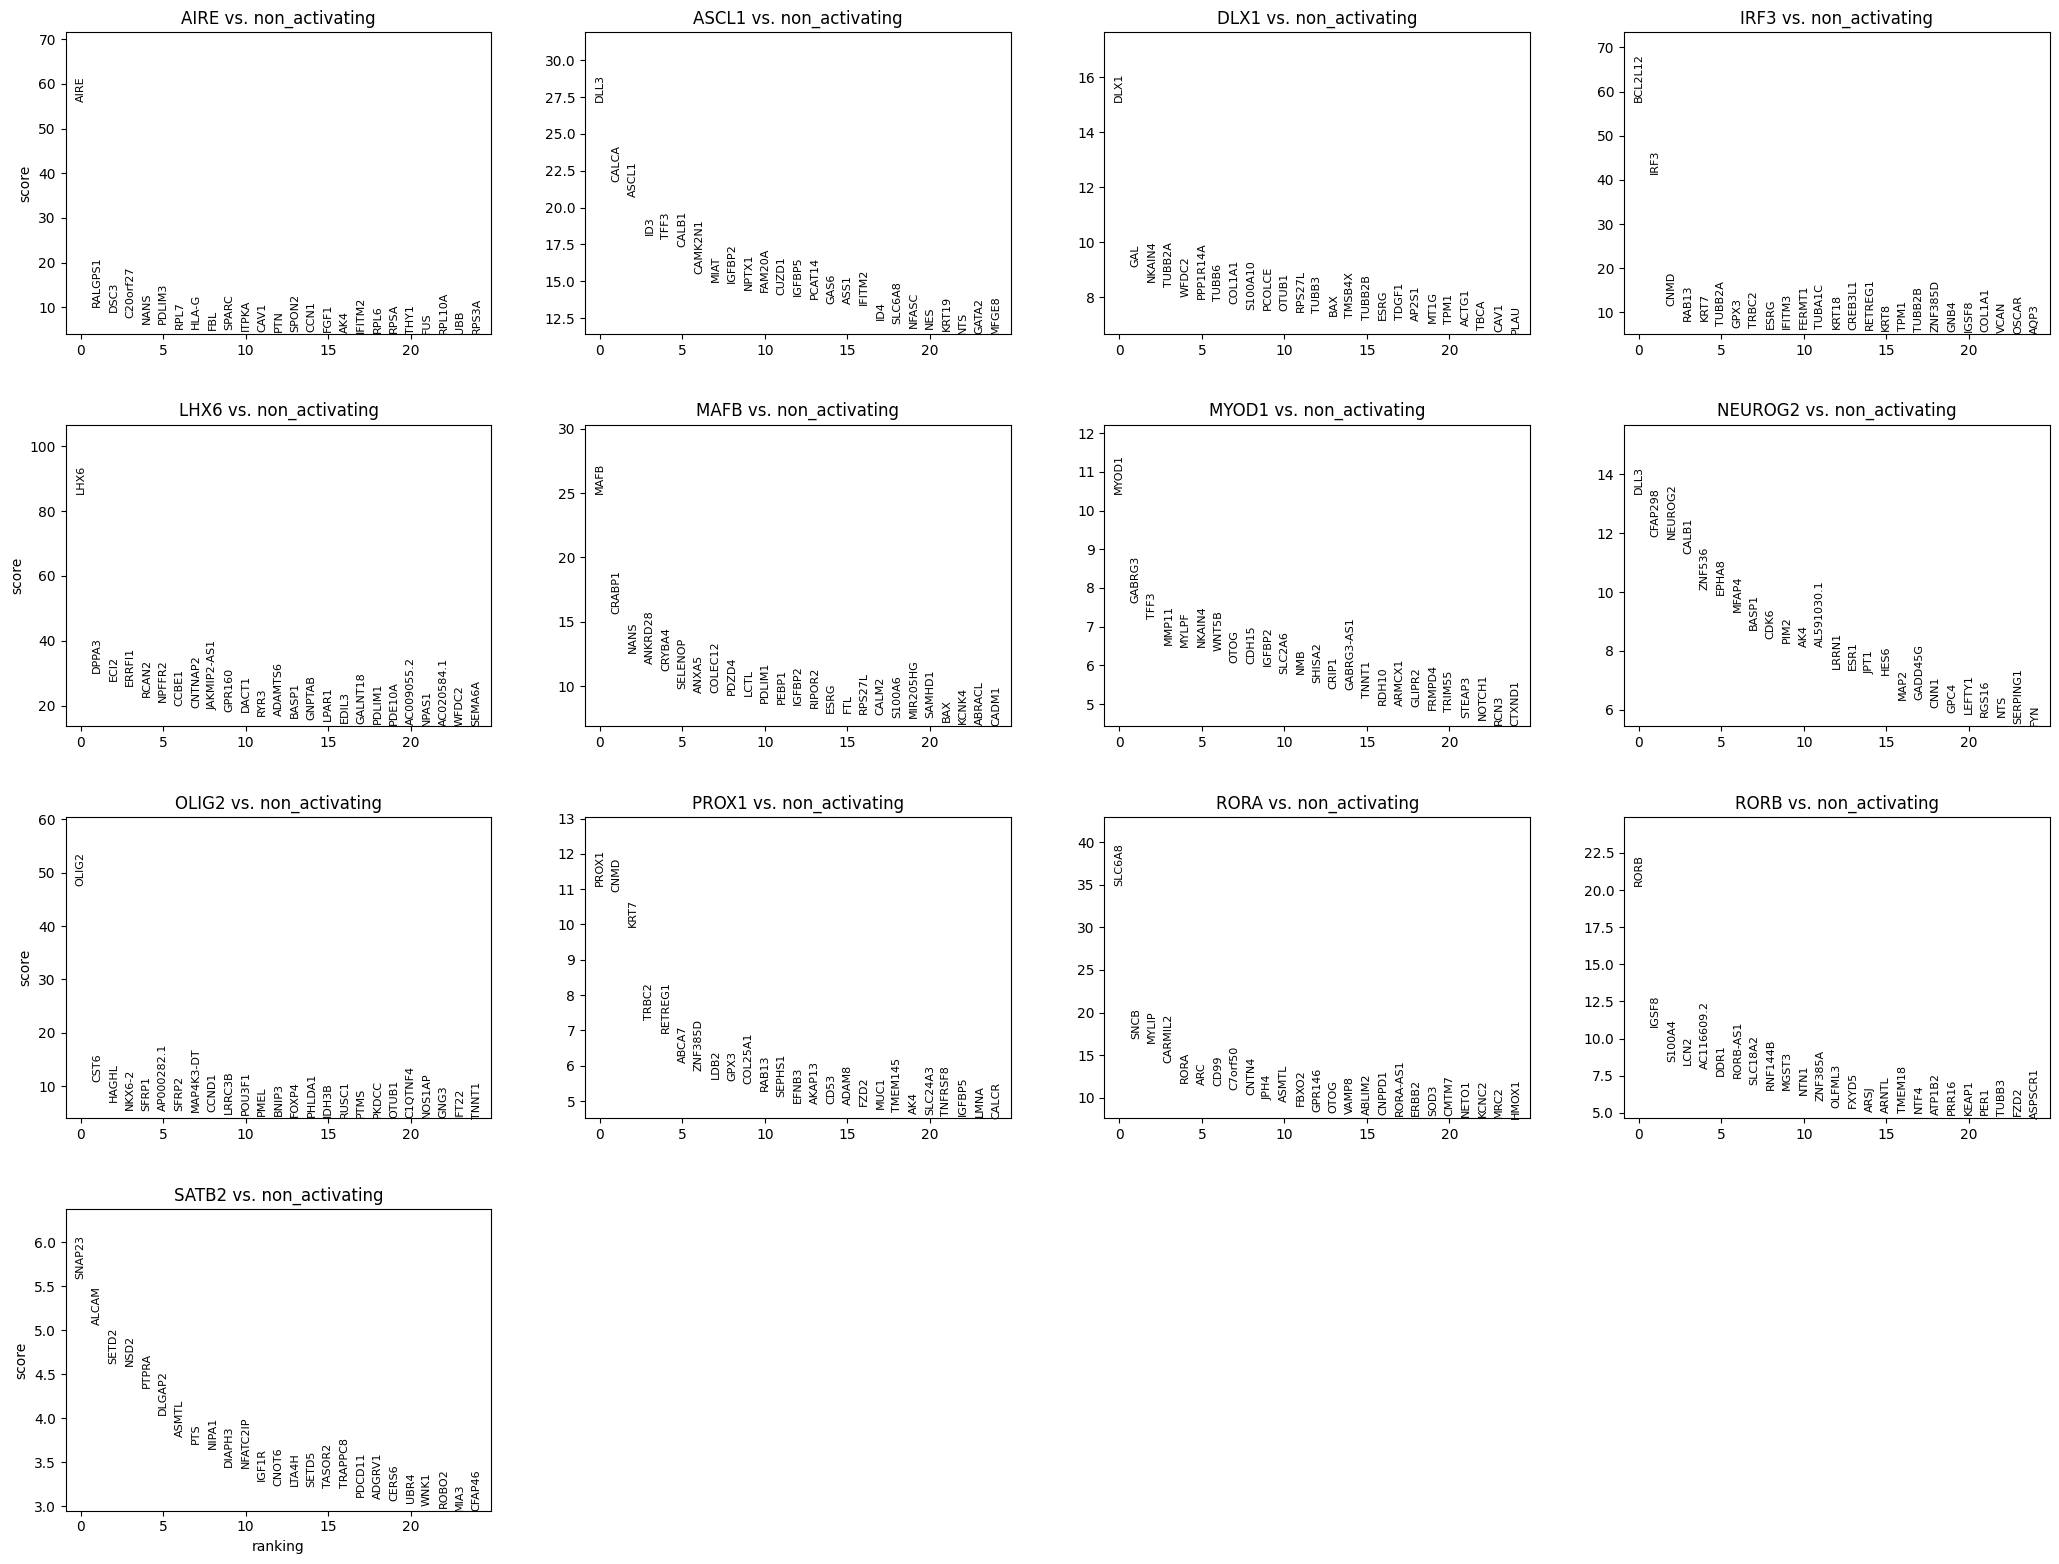

In [12]:
#create list of perturbation states excluding the control state
perturbation_states = adata_filter_leiden.obs['perturbation_state'].unique().tolist()
perturbation_states.remove('non_activating')
#ranked genes pertubed compared to non-activatedb as reference
sc.tl.rank_genes_groups(adata_filter_leiden, 'perturbation_state', reference='non_activating', method='t-test', layer='log1p')
sc.pl.rank_genes_groups(adata_filter_leiden, n_genes=25, sharey=False, gene_symbols='SYMBOL')


In [13]:
#extracting log2 fold change and p values for each perturbation state from tl.rank_genes_groups
#and create list of pandas dataframe
perturbation_state_ranked_genes = []
for perturbation_state in perturbation_states:
    df = pd.DataFrame(adata_filter_leiden.uns['rank_genes_groups']['names'][perturbation_state])
    df['log2_fold_change'] = adata_filter_leiden.uns['rank_genes_groups']['logfoldchanges'][perturbation_state]
    df['pvals'] = adata_filter_leiden.uns['rank_genes_groups']['pvals'][perturbation_state]
    df['pvals_adj'] = adata_filter_leiden.uns['rank_genes_groups']['pvals_adj'][perturbation_state]
    df['perturbation_state'] = perturbation_state
    #df column 0 is the gene ids
    df['names'] = df[0]
    #drop column 0
    df = df.drop(columns=0)
    #map gene symbols to gene ids
    df['SYMBOL'] = df['names'].map(adata_filter_leiden.var['SYMBOL'])
    perturbation_state_ranked_genes.append(df)




In [19]:
perturbation_state_ranked_genes[0]

,log2_fold_change,pvals,pvals_adj,perturbation_state,names,SYMBOL
0,6.119135,0.000000e+00,0.000000e+00,LHX6,ENSG00000106852,LHX6
1,4.366598,1.169727e-144,9.303421e-141,LHX6,ENSG00000187569,DPPA3
2,1.804004,2.760661e-137,1.463794e-133,LHX6,ENSG00000198721,ECI2
3,1.977964,1.354675e-125,5.387202e-122,LHX6,ENSG00000116285,ERRFI1
4,2.244828,5.979906e-98,1.902447e-94,LHX6,ENSG00000172348,RCAN2
...,...,...,...,...,...,...
15902,-0.956435,5.124958e-23,1.101658e-20,LHX6,ENSG00000204711,C9orf135
15903,-0.709034,3.072132e-23,6.882874e-21,LHX6,ENSG00000128294,TPST2
15904,-0.703704,8.500628e-27,2.414634e-24,LHX6,ENSG00000136110,CNMD
15905,-1.863199,2.672186e-51,2.656654e-48,LHX6,ENSG00000248329,APELA


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_39142/3589389767.py:17: RuntimeWarning: divide by zero encountered in log10
  ax.annotate(gene, (perturbation_state_ranked_genes[i]['log2_fold_change'][j], -np.log10(perturbation_state_ranked_genes[i]['pvals_adj'][j])))
/tmp/ipykernel_39142/3589389767.py:21: RuntimeWarning: divide by zero encountered in log10
  -np.log10(perturbation_state_ranked_genes[i]['pvals_adj'][j]),


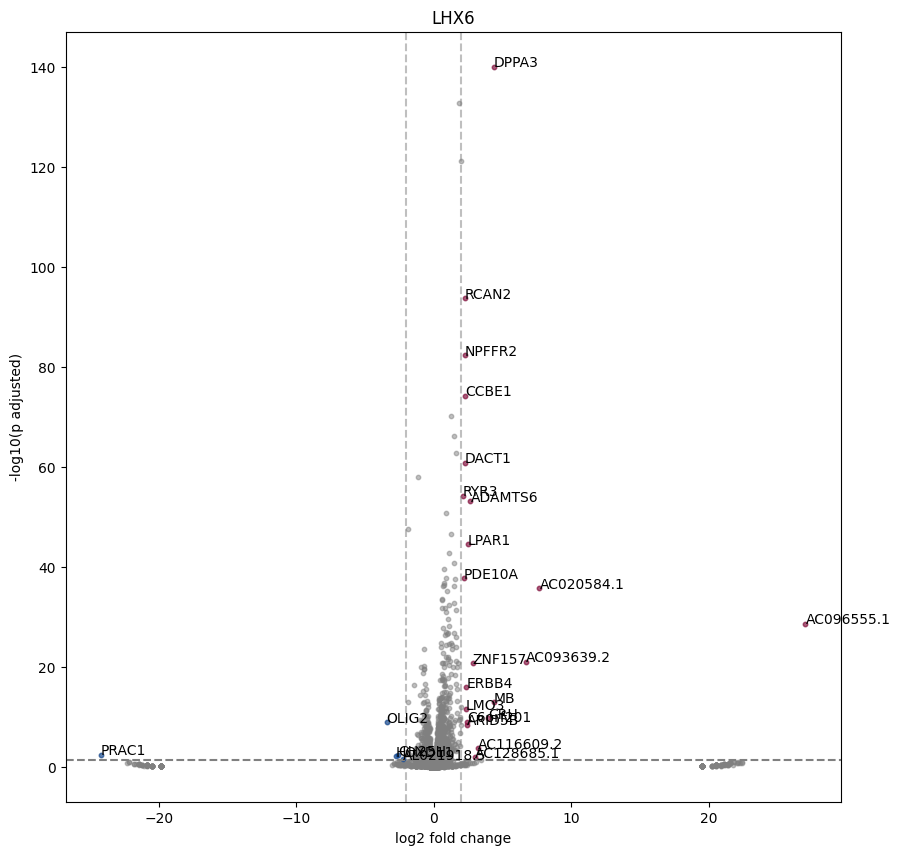

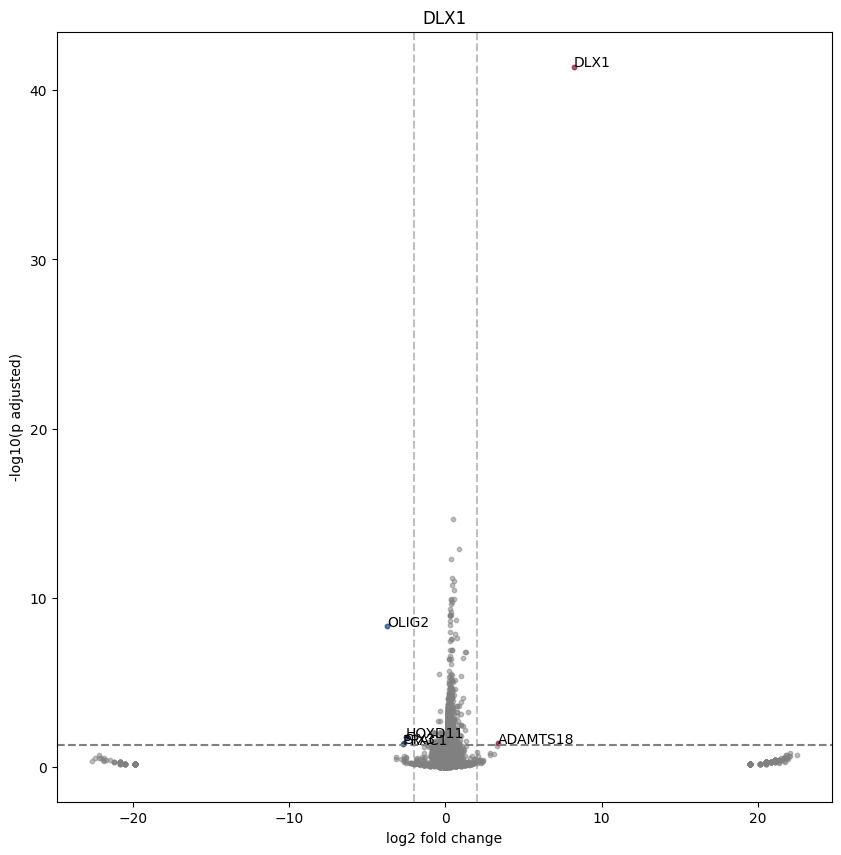

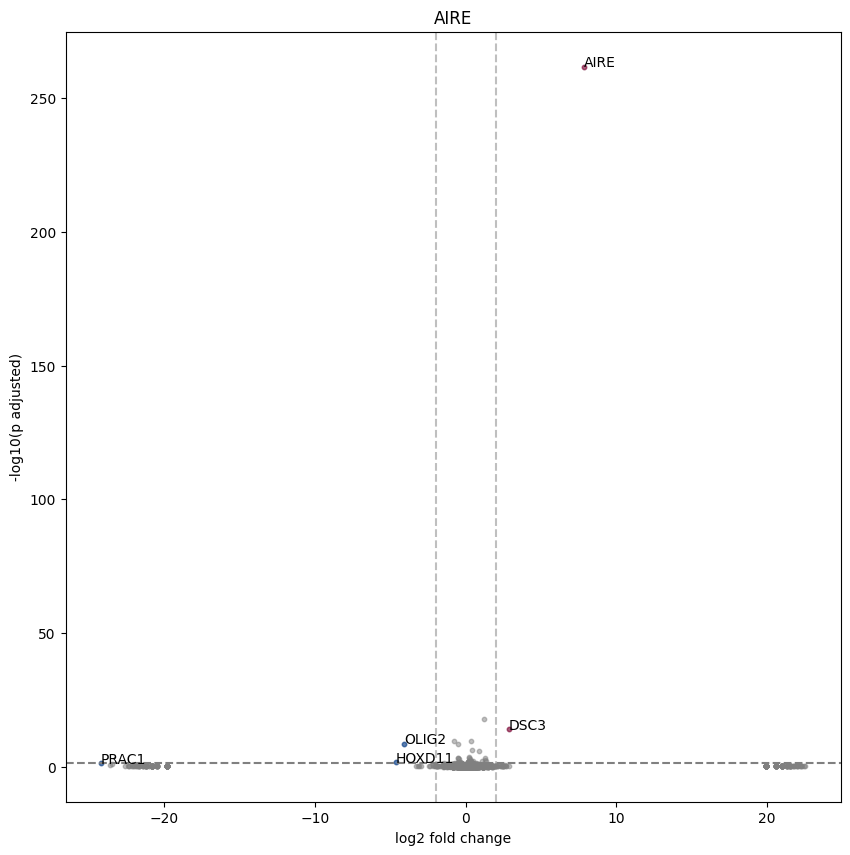

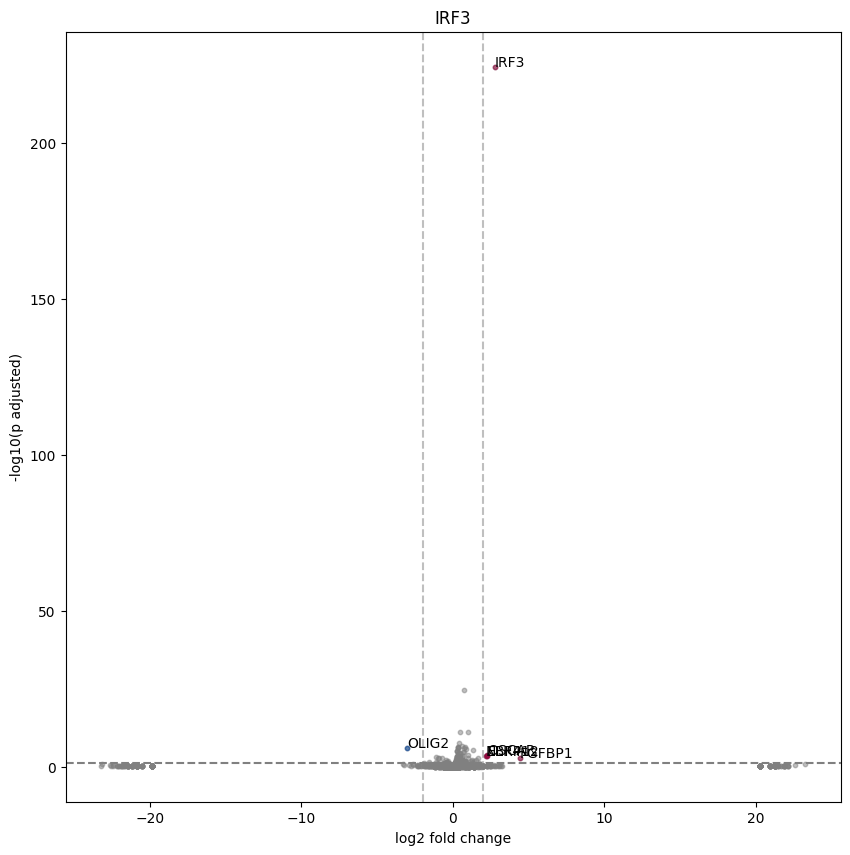

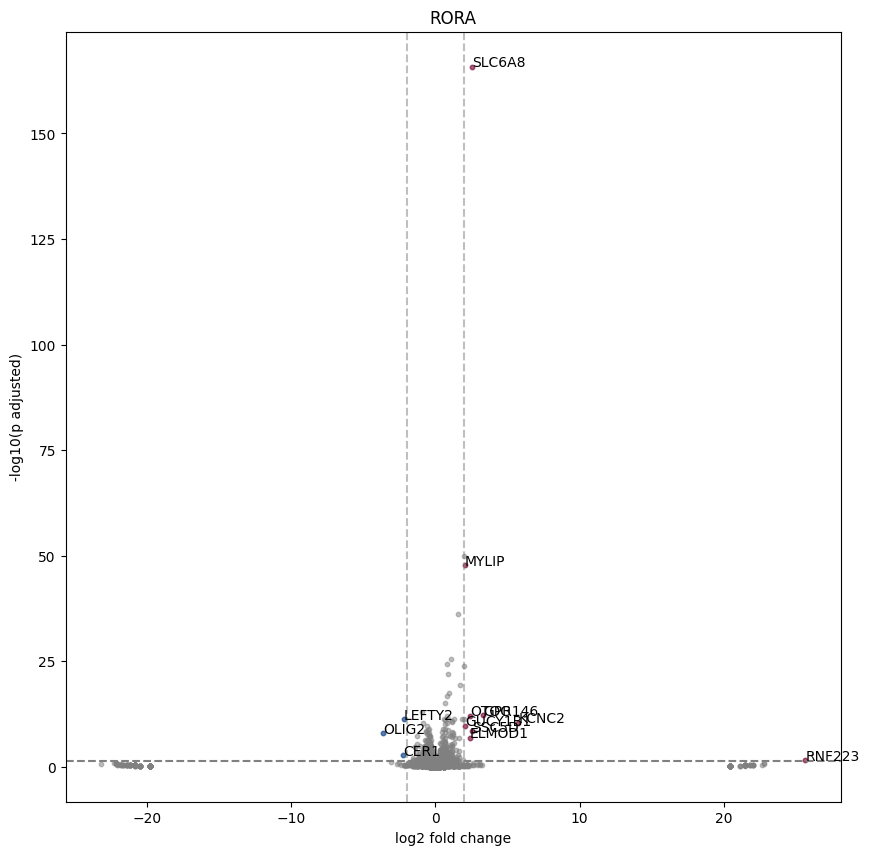

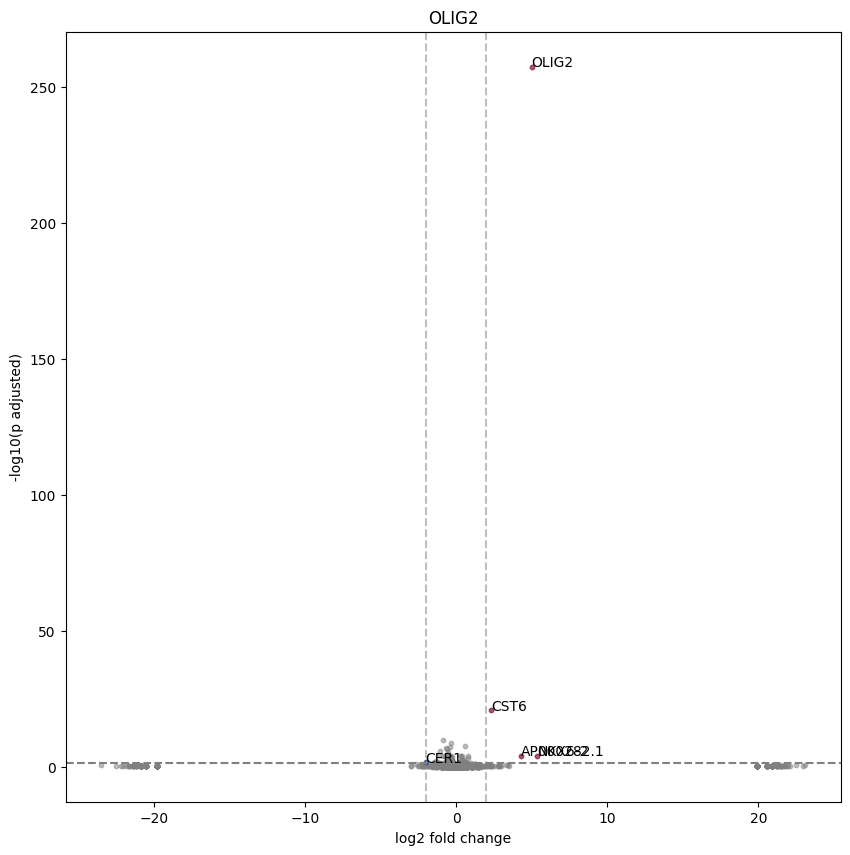

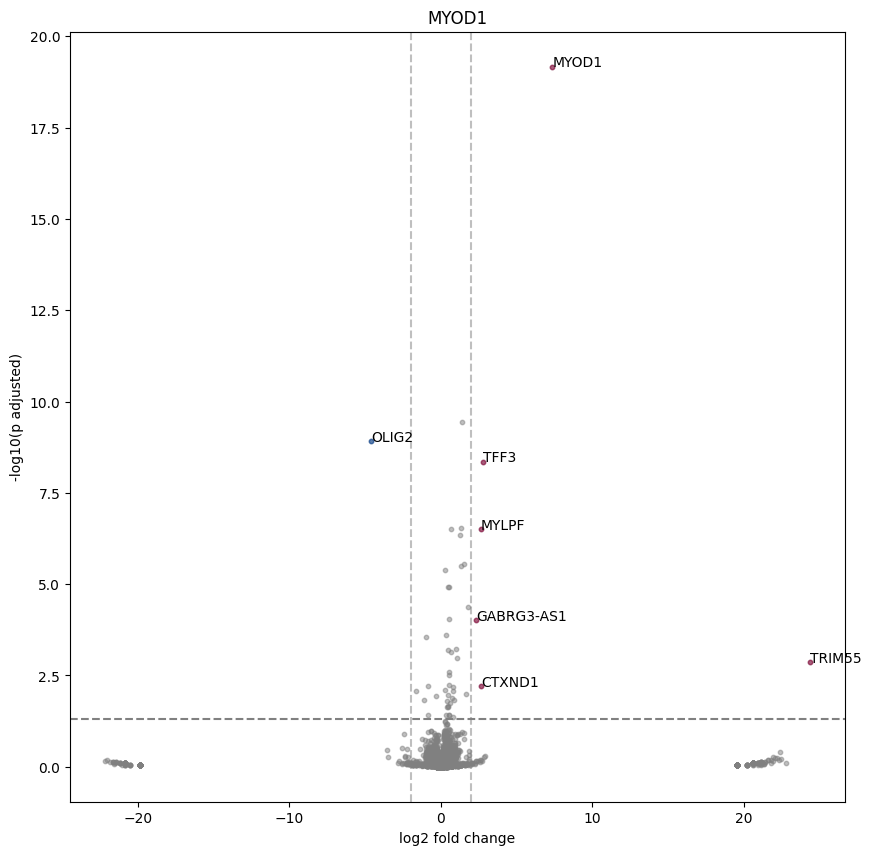

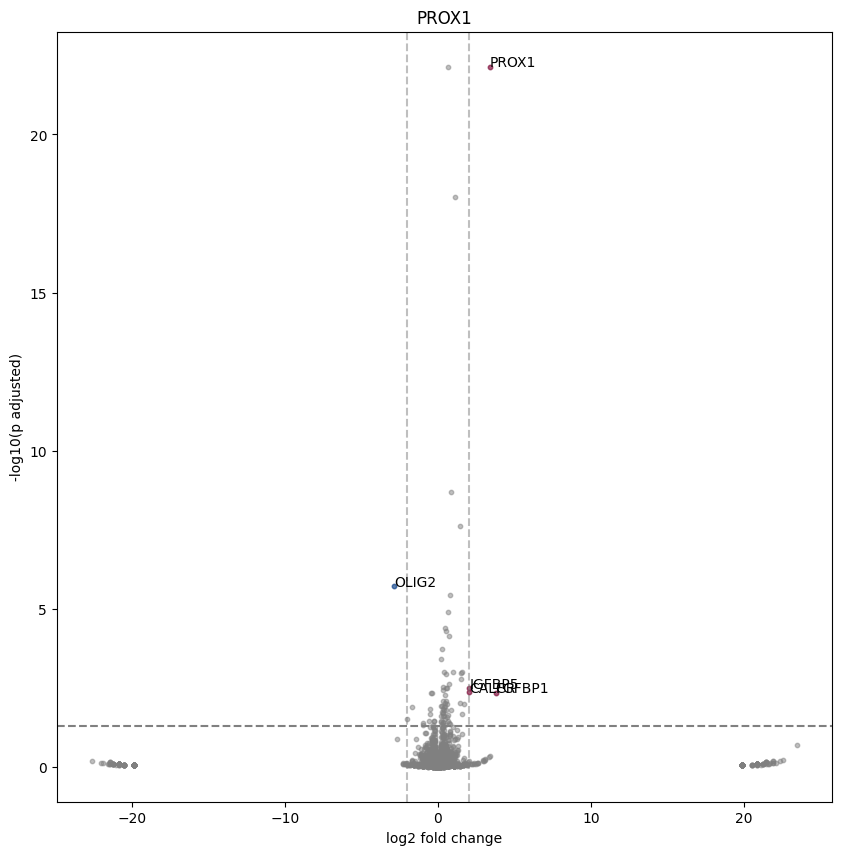

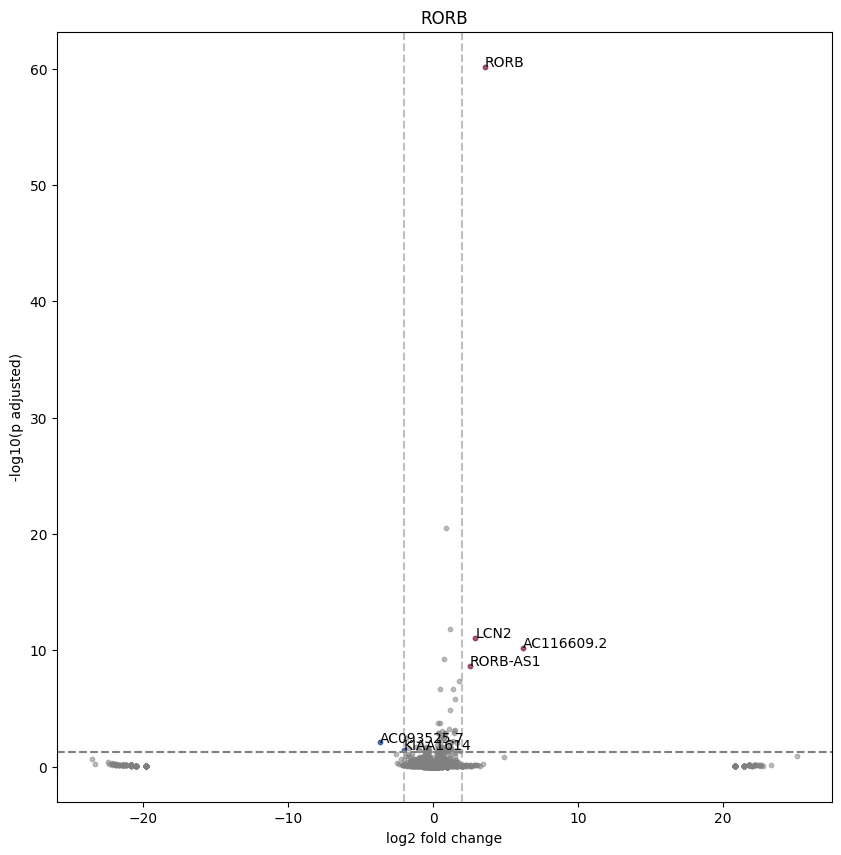

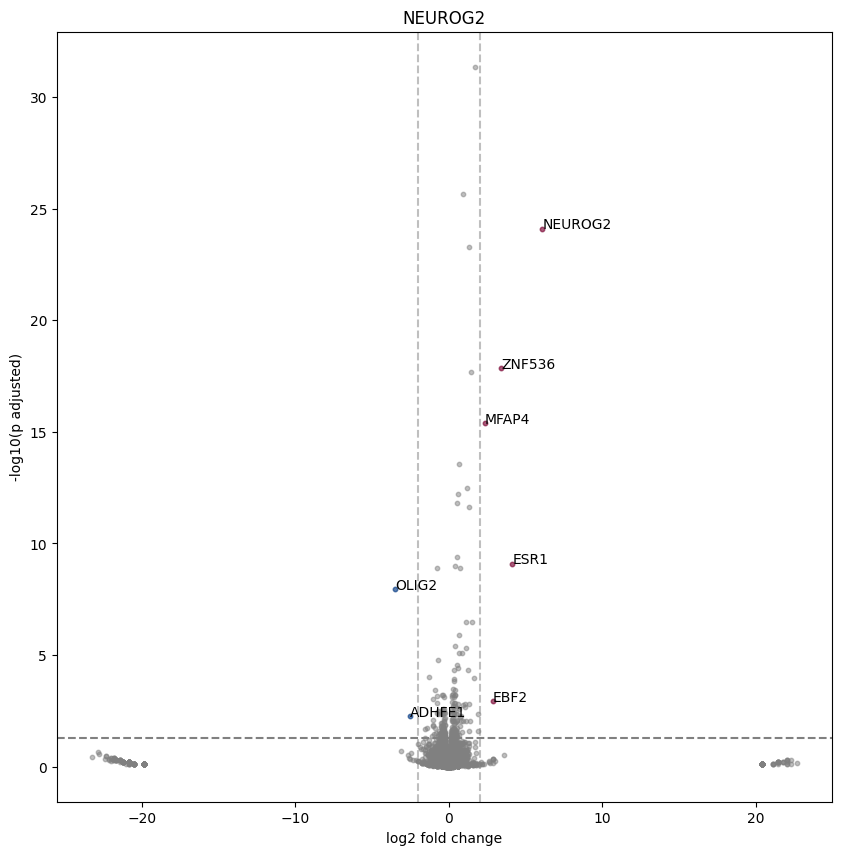

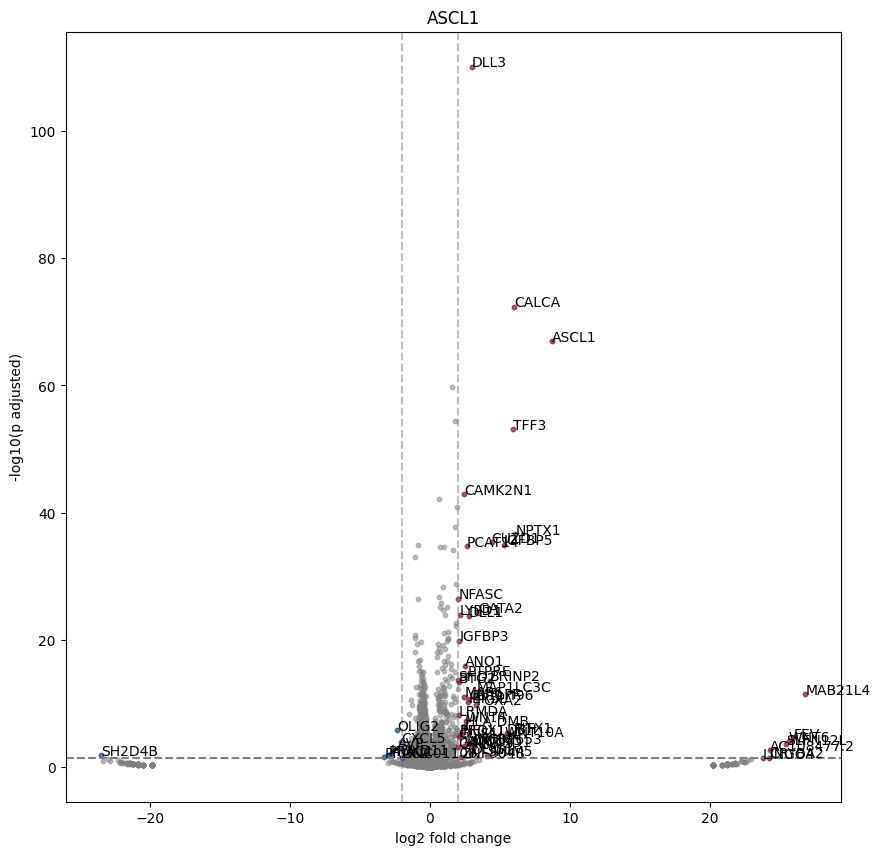

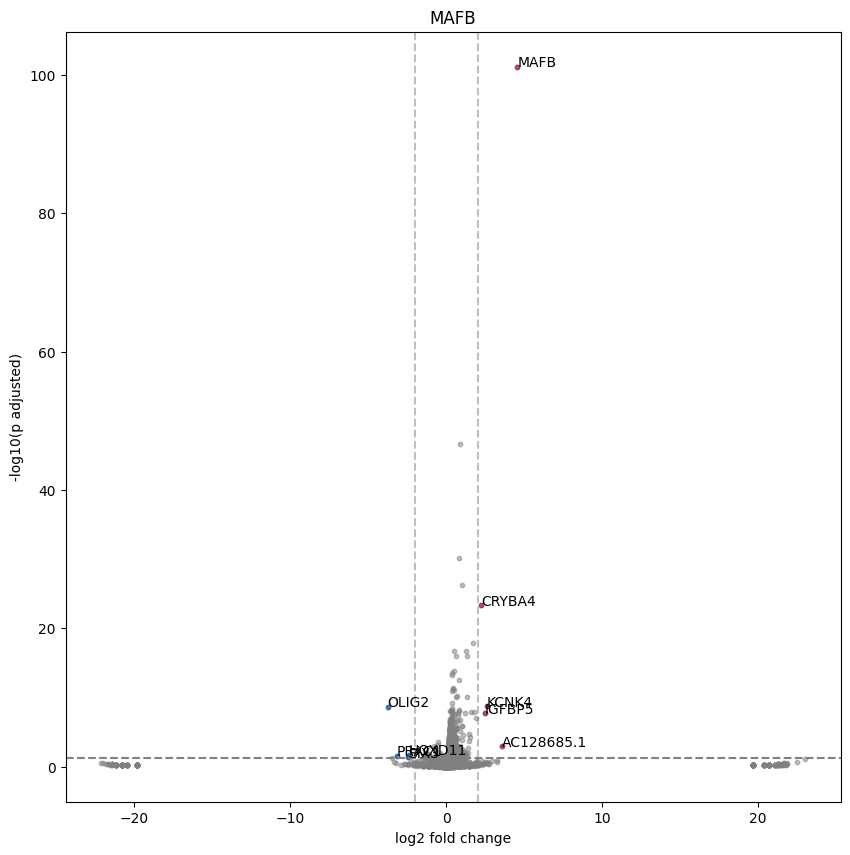

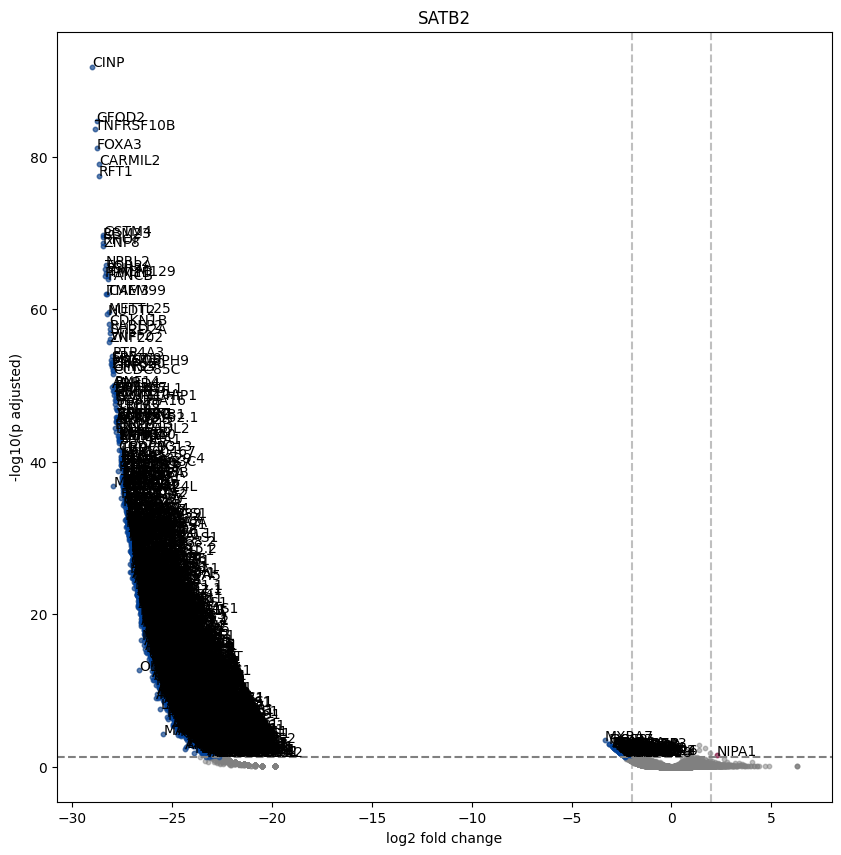

In [37]:
#create volcano plot for each perturbation state using log2 fold change and p adjusted values
#label genes with log2 fold change > 3 and p adjusted < 0.05
for i, perturbation_state in enumerate(perturbation_states):
    fig, ax = plt.subplots(figsize=(10, 10))
    #create boundaries for upregulated and downregulated genes based on log2 fold change and p adjusted values 
    ax.axhline(-np.log10(0.05), color='grey', linestyle='--')
    ax.axvline(-2, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(2, color='grey', linestyle='--', alpha=0.5)

    ax.scatter(
        perturbation_state_ranked_genes[i]['log2_fold_change'], 
        -np.log10(perturbation_state_ranked_genes[i]['pvals_adj']),
        s=10, alpha=0.5, color='grey')
    #label genes with log2 fold change > 3 and p adjusted < 0.05 with the gene name found in gene symbols
    for j, gene in enumerate(perturbation_state_ranked_genes[i]['SYMBOL']):
        if (perturbation_state_ranked_genes[i]['log2_fold_change'][j] > 2) and (perturbation_state_ranked_genes[i]['pvals_adj'][j] < 0.05):
            ax.annotate(gene, (perturbation_state_ranked_genes[i]['log2_fold_change'][j], -np.log10(perturbation_state_ranked_genes[i]['pvals_adj'][j])))
            #plot in red
            ax.scatter(
                perturbation_state_ranked_genes[i]['log2_fold_change'][j],
                -np.log10(perturbation_state_ranked_genes[i]['pvals_adj'][j]),
                s=10, alpha=0.5, color='#93003a')
        elif (perturbation_state_ranked_genes[i]['log2_fold_change'][j] < -2) and (perturbation_state_ranked_genes[i]['pvals_adj'][j] < 0.05):
            ax.annotate(gene, (perturbation_state_ranked_genes[i]['log2_fold_change'][j], -np.log10(perturbation_state_ranked_genes[i]['pvals_adj'][j])))
            #plot in blue
            ax.scatter(
                perturbation_state_ranked_genes[i]['log2_fold_change'][j],
                -np.log10(perturbation_state_ranked_genes[i]['pvals_adj'][j]),
                s=10, alpha=0.5, color='#00429d')


    ax.set_xlabel('log2 fold change')
    ax.set_ylabel('-log10(p adjusted)')
    ax.set_title(perturbation_state)
    plt.show()

In [ ]:
#compare to clean ipsc data 